# Exercise 9 - Solution 

* You can find a reference implementation of the Ghil-Sellers EBM as a package on [GitHub](https://github.com/maximilian-gelbrecht/GhilSellersEBM.jl), this packge will also be used in this solution

## Basin Boundary 

From the last animation from the lecture, we've seen that the basin boundary must be somewhere between $260 K$ and $280 K$. The basin boundary of the model is a saddle point, trajectories that start very close to it will remain there for quite a long time until converging to one of the stable fixed points. This model only has those two fixed points within the interval of initial conditions that is interesting to us, we will therefore assume that every trajectory those average temperature at a later point in time is smaller than the intial condtion will eventually reach the cold stable fixed. 

In [1]:
import Pkg 
Pkg.activate(temp=true)
Pkg.add("OrdinaryDiffEq")
Pkg.add("StatsBase")
Pkg.add("Plots")
Pkg.add(url="https://github.com/maximilian-gelbrecht/GhilSellersEBM.jl.git")

  Activating new project at `/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_qsD2LZ`
   Resolving package versions...
    Updating `/private/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_qsD2LZ/Project.toml`
⌅ [1dea7af3] + OrdinaryDiffEq v6.66.0
    Updating `/private/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_qsD2LZ/Manifest.toml`
  [47edcb42] + ADTypes v0.2.6
⌅ [79e6a3ab] + Adapt v3.7.2
  [ec485272] + ArnoldiMethod v0.2.0
  [4fba245c] + ArrayInterface v7.7.0
  [4c555306] + ArrayLayouts v1.5.0
  [62783981] + BitTwiddlingConvenienceFunctions v0.1.5
  [2a0fbf3d] + CPUSummary v0.2.4
  [fb6a15b2] + CloseOpenIntervals v0.1.12
  [38540f10] + CommonSolve v0.2.4
  [bbf7d656] + CommonSubexpressions v0.3.0
  [34da2185] + Compat v4.10.1
  [2569d6c7] + ConcreteStructs v0.2.3
  [187b0558] + ConstructionBase v1.5.4
  [adafc99b] + CpuId v0.3.1
  [9a962f9c] + DataAPI v1.15.0
  [864edb3b] + DataStructures v0.18.16
  [e2d170a0] + DataValueInterfaces v1.0.0
  [2b5f629d] + DiffEqBase v6.

   Resolving package versions...
    Updating `/private/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_qsD2LZ/Project.toml`
  [2913bbd2] + StatsBase v0.34.2
    Updating `/private/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_qsD2LZ/Manifest.toml`
  [e1d29d7a] + Missings v1.1.0
  [a2af1166] + SortingAlgorithms v1.2.1
  [82ae8749] + StatsAPI v1.7.0
  [2913bbd2] + StatsBase v0.34.2
   Resolving package versions...
    Updating `/private/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_qsD2LZ/Project.toml`
  [91a5bcdd] + Plots v1.39.0
    Updating `/private/var/folders/vh/kv_4zdr96jz7s12j89cjcl780000gn/T/jl_qsD2LZ/Manifest.toml`
  [d1d4a3ce] + BitFlags v0.1.8
  [944b1d66] + CodecZlib v0.7.3
  [35d6a980] + ColorSchemes v3.24.0
  [3da002f7] + ColorTypes v0.11.4
  [c3611d14] + ColorVectorSpace v0.10.0
  [5ae59095] + Colors v0.12.10
  [f0e56b4a] + ConcurrentUtilities v2.3.0
  [d38c429a] + Contour v0.6.2
  [8bb1440f] + DelimitedFiles v1.9.1
  [460bff9d] + ExceptionUnwrapping v0.1.10

⌃ [13072b0f] + AxisAlgorithms v1.0.1
  [d360d2e6] + ChainRulesCore v1.19.0
  [384e9d69] + GhilSellersEBM v0.1.1 `https://github.com/maximilian-gelbrecht/GhilSellersEBM.jl.git#main`
⌃ [a98d9a8b] + Interpolations v0.14.7
  [c84ed2f1] + Ratios v0.4.5
⌅ [efce3f68] + WoodburyMatrices v0.5.6
        Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated -m`


In [2]:
using GhilSellersEBM, StatsBase, OrdinaryDiffEq, Plots

x = (-90.:5.:90.)./90.
grid = Grid(x)
p = ContinousGhilSellersParameters(grid, order="2nd");

function final_temperature(T_0, p, tspan=(0.,1e9))
        prob = ODEProblem(ghilsellers_ebm!, T_0 .* ones(Float64, p.g.N), tspan, p)
        sol = solve(prob, Tsit5())
        mean(sol(tspan[2]))
end 

final_temperature (generic function with 2 methods)

In [3]:
T_0s = 260:1:280
T_fs = [final_temperature(T,p) for T ∈ T_0s]

21-element Vector{Float64}:
 218.55315862269825
 218.55786721292898
 218.5614323649152
 218.56700501385532
 218.57631265755438
 218.59061073017105
 218.6160316915425
 218.66314263016096
 218.75959048867298
 219.0477291099575
 222.36397040911436
 275.59940501398466
 277.11659545545064
 277.7120054796569
 278.04835789572843
 278.26415386400424
 278.43705493273507
 278.56939892172574
 278.6703187614282
 278.75515734992786
 278.8229346161707

So, the basin boundary is somewhere between 270 K and 272 K. Let's compute it a little closer, also increasing the `tspan`

In [4]:
function which_basin(T_0, p) 
    if final_temperature(T_0,p,(0.,1e10)) < T_0
        return "cold"
    else
        return "warm"
    end 
end

T_0s = 270:0.1:272
basins = [which_basin(T_0,p) for T_0 ∈ T_0s] 

21-element Vector{String}:
 "cold"
 "cold"
 "cold"
 "cold"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"
 "warm"

We could now zoom into that region even further, potentially also with some more proper algorithm to save some computations, but the model itself is also only a conceptual, coarse model, so we will leave our estimate for the basin bounday at $T_c=270.35K$

Let's look at some trajectories very close to it! They will remain for a really long time close the unstable saddle point. [Lucarini et al](https://iopscience.iop.org/article/10.1088/1361-6544/ab86cc/meta) coined the term 'Melancholia states' for these kind of states. We will massively increase the integration time:



In [5]:
tspan = (0.,1e9)
prob = ODEProblem(ghilsellers_ebm!, 270.3 .* ones(Float64, p.g.N), tspan, p)
sol_1 = solve(prob, Tsit5())
sol_2 = solve(remake(prob, u0=270.4 .* ones(Float64, p.g.N)), Tsit5());
sol_3 = solve(remake(prob, u0=270.2 .* ones(Float64, p.g.N)), Tsit5());

[ Info: Saved animation to /Users/max/Nextcloud/TUM-Dynamics-Lecture/exercises/exercise-9/ebm-anim.gif


Plots.AnimatedGif("/Users/max/Nextcloud/TUM-Dynamics-Lecture/exercises/exercise-9/ebm-anim.gif")
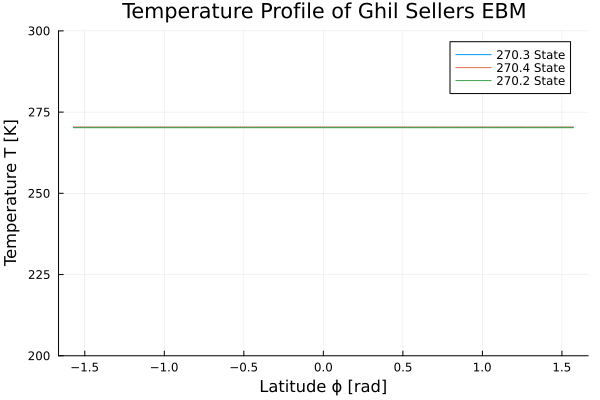

In [6]:
t_plot = range(tspan[1],tspan[2],length=200)
anim = @animate for it ∈ t_plot
    plot(p.ϕ, sol_1(it), xlabel="Latitude ϕ [rad]", label="270.3 State", ylims=[210,300], ylabel="Temperature T [K]", title="Temperature Profile of Ghil Sellers EBM")
    plot!(p.ϕ, sol_2(it), label="270.4 State", ylims=[200,300])
    plot!(p.ϕ, sol_3(it), label="270.2 State", ylims=[200,300])


end 
gif(anim, "ebm-anim.gif", fps=10)

We see numerical inaccuricies accumulating at this point. Let's compute them with a lower solver tolerance. As a comparision we also include some solutions that start far away from the saddle point

In [7]:
tspan=(0.,1e10)
prob = ODEProblem(ghilsellers_ebm!, 270.3 .* ones(Float64, p.g.N), tspan, p)
sol_1 = solve(prob, Tsit5(), reltol=1e-6)
sol_2 = solve(remake(prob, u0=270.4 .* ones(Float64, p.g.N)), Tsit5(), reltol=1e-6);
sol_3 = solve(remake(prob, u0=270.2 .* ones(Float64, p.g.N)), Tsit5(), reltol=1e-6);
sol_4 = solve(remake(prob, u0=285 .* ones(Float64, p.g.N)), Tsit5(), reltol=1e-4);
sol_5 = solve(remake(prob, u0=255 .* ones(Float64, p.g.N)), Tsit5(), reltol=1e-4);

[ Info: Saved animation to /Users/max/Nextcloud/TUM-Dynamics-Lecture/exercises/exercise-9/ebm-anim.gif


Plots.AnimatedGif("/Users/max/Nextcloud/TUM-Dynamics-Lecture/exercises/exercise-9/ebm-anim.gif")
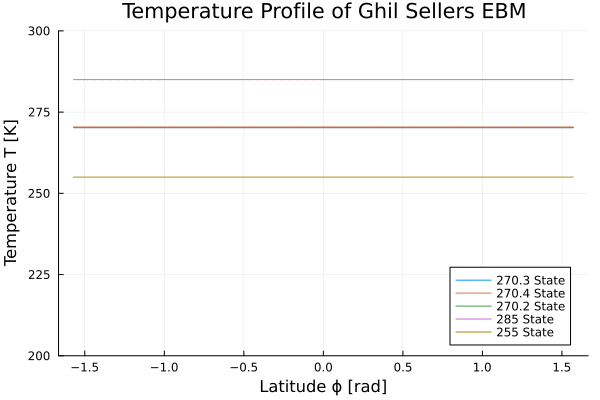

In [8]:
t_plot = range(tspan[1],tspan[2],length=200)

anim = @animate for it ∈ t_plot
  plot(p.ϕ, sol_1(it), xlabel="Latitude ϕ [rad]", label="270.3 State", ylims=[210,300], ylabel="Temperature T [K]", title="Temperature Profile of Ghil Sellers EBM")
  plot!(p.ϕ, sol_2(it), label="270.4 State", ylims=[200,300])
  plot!(p.ϕ, sol_3(it), label="270.2 State", ylims=[200,300])
  plot!(p.ϕ, sol_4(it), label="285 State", ylims=[200,300])
  plot!(p.ϕ, sol_5(it), label="255 State", ylims=[200,300])
end 
gif(anim, "ebm-anim.gif", fps=10)

We could mitigate the numerical issues further, when we would use higher order finite difference schemes, e.g. a fourth order central difference scheme. Very close to the unstable saddle points these errors start to accumulate and we are not able to compute the trajectory properly anymore. 

## Fourth Order Finite Differences 

* You can look up the coefficients on [Wikipedia](https://en.wikipedia.org/wiki/Finite_difference_coefficient)
* The GitHub repo also features this scheme [as well](https://github.com/maximilian-gelbrecht/GhilSellersEBM.jl/blob/main/src/discretization.jl)
* Let's redo the last experiment with this: 

In [9]:
p = ContinousGhilSellersParameters(grid, order="4th")
tspan=(0.,1e10)
prob = ODEProblem(ghilsellers_ebm!, 270.3 .* ones(Float64, p.g.N), tspan, p)
sol_1 = solve(prob, Tsit5(), reltol=1e-6)
sol_2 = solve(remake(prob, u0=270.4 .* ones(Float64, p.g.N)), Tsit5(), reltol=1e-6);
sol_3 = solve(remake(prob, u0=270.2 .* ones(Float64, p.g.N)), Tsit5(), reltol=1e-6);
sol_4 = solve(remake(prob, u0=285 .* ones(Float64, p.g.N)), Tsit5(), reltol=1e-4);
sol_5 = solve(remake(prob, u0=255 .* ones(Float64, p.g.N)), Tsit5(), reltol=1e-4);

[ Info: Saved animation to /Users/max/Nextcloud/TUM-Dynamics-Lecture/exercises/exercise-9/ebm-anim-4th.gif


Plots.AnimatedGif("/Users/max/Nextcloud/TUM-Dynamics-Lecture/exercises/exercise-9/ebm-anim-4th.gif")
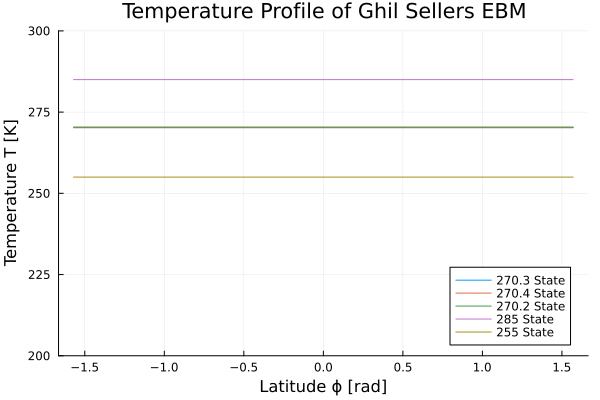

In [10]:
t_plot = range(tspan[1],tspan[2],length=200)

anim = @animate for it ∈ t_plot
  plot(p.ϕ, sol_1(it), xlabel="Latitude ϕ [rad]", label="270.3 State", ylims=[210,300], ylabel="Temperature T [K]", title="Temperature Profile of Ghil Sellers EBM")
  plot!(p.ϕ, sol_2(it), label="270.4 State", ylims=[200,300])
  plot!(p.ϕ, sol_3(it), label="270.2 State", ylims=[200,300])
  plot!(p.ϕ, sol_4(it), label="285 State", ylims=[200,300])
  plot!(p.ϕ, sol_5(it), label="255 State", ylims=[200,300])
end 
gif(anim, "ebm-anim-4th.gif", fps=10)

We see that using a more accurate finite difference scheme helps solving the equation close the basin boundary. For an even further improved version, we can also use alternatives to finite differences. In last year's class Joris [implemented a finite element version as his final project](https://github.com/joristh/DiffusionSplineFE.jl).

## Bifurcation Diagram

(executing the code below might take a while (~5 minutes)

In [26]:
μs = 0.95:0.001:1.02
u0s = 210:10:290

tspan=(0.,5e9)
prob = ODEProblem(ghilsellers_ebm!, 300 .* ones(Float64, p.g.N), tspan, p)


bif_diagram = zeros(length(μs)*length(u0s),2)
count = 1
for μ ∈ μs
    p = ContinousGhilSellersParameters(grid, μ=μ)
    for u0 ∈ u0s 
        bif_diagram[count, 1] = μ
        bif_diagram[count, 2] = mean(solve(remake(prob,p=p,u0=u0*ones(Float64, p.g.N)), Tsit5(),reltol=1e-6).u[end])
        count += 1 
    end 
    println(string("Progress: μ = ",μ))
end 


Progress: μ = 0.95
Progress: μ = 0.951
Progress: μ = 0.952
Progress: μ = 0.953
Progress: μ = 0.954
Progress: μ = 0.955
Progress: μ = 0.956
Progress: μ = 0.957
Progress: μ = 0.958
Progress: μ = 0.959
Progress: μ = 0.96
Progress: μ = 0.961
Progress: μ = 0.962
Progress: μ = 0.963
Progress: μ = 0.964
Progress: μ = 0.965
Progress: μ = 0.966
Progress: μ = 0.967
Progress: μ = 0.968
Progress: μ = 0.969
Progress: μ = 0.97
Progress: μ = 0.971
Progress: μ = 0.972
Progress: μ = 0.973
Progress: μ = 0.974
Progress: μ = 0.975
Progress: μ = 0.976
Progress: μ = 0.977
Progress: μ = 0.978
Progress: μ = 0.979
Progress: μ = 0.98
Progress: μ = 0.981
Progress: μ = 0.982
Progress: μ = 0.983
Progress: μ = 0.984
Progress: μ = 0.985
Progress: μ = 0.986
Progress: μ = 0.987
Progress: μ = 0.988
Progress: μ = 0.989
Progress: μ = 0.99
Progress: μ = 0.991
Progress: μ = 0.992
Progress: μ = 0.993
Progress: μ = 0.994
Progress: μ = 0.995
Progress: μ = 0.996
Progress: μ = 0.997
Progress: μ = 0.998
Progress: μ = 0.999
Progr

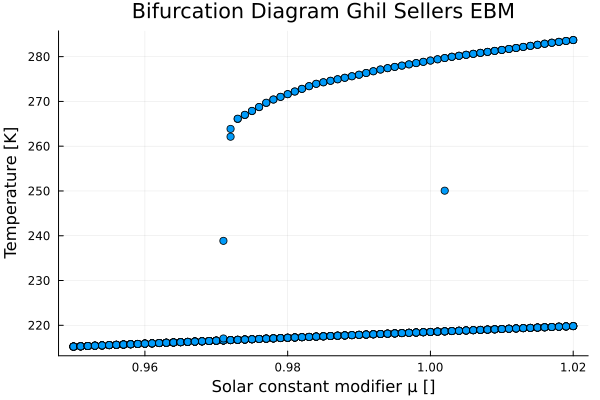

In [27]:
scatter(bif_diagram[:,1],bif_diagram[:,2],legend=nothing, xlabel="Solar constant modifier μ []", ylabel="Temperature [K]", title="Bifurcation Diagram Ghil Sellers EBM")

The two isolated points that you see there are very likely states that start very close to the basin boundary and remain there much longer, we could redo the diagram with an even larger integration time to avoid this